In [4]:
import pandas as pd

# Load datasets
train_df = pd.read_csv("../data/train.csv")
test_df = pd.read_csv("../data/test.csv")

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

print(train_df.head())
print(test_df.head())


Train shape: (913000, 4)
Test shape: (45000, 4)
         date  store  item  sales
0  2013-01-01      1     1     13
1  2013-01-02      1     1     11
2  2013-01-03      1     1     14
3  2013-01-04      1     1     13
4  2013-01-05      1     1     10
   id        date  store  item
0   0  2018-01-01      1     1
1   1  2018-01-02      1     1
2   2  2018-01-03      1     1
3   3  2018-01-04      1     1
4   4  2018-01-05      1     1


In [13]:
# Convert date column
train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])

# Aggregate sales (total sales per day)
daily_sales = train_df.groupby("date")['sales'].sum().reset_index()

# Rename for Prophet
df_prophet = daily_sales.rename(columns={'date': 'ds', 'sales': 'y'})


# Train Prophet Model

19:28:33 - cmdstanpy - INFO - Chain [1] start processing
19:28:35 - cmdstanpy - INFO - Chain [1] done processing


MAE: 1020.657771976662
RMSE: 1388.7161848625285


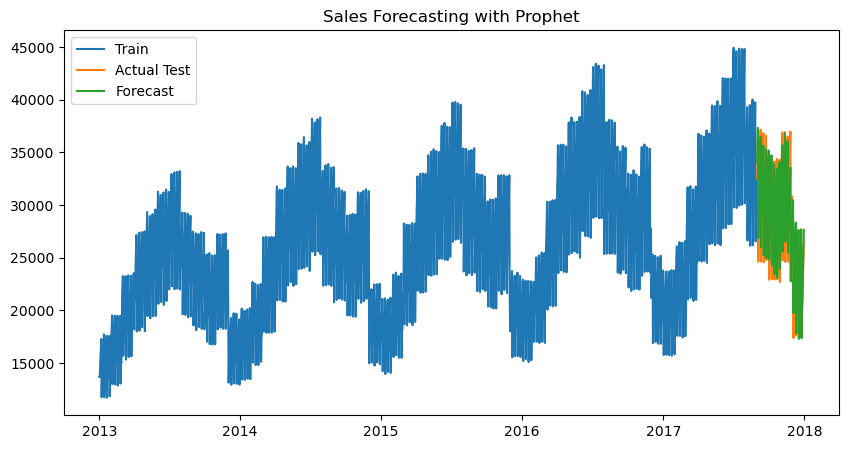

In [17]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("../data/train.csv")
df['date'] = pd.to_datetime(df['date'])

# Aggregate sales (total sales per day)
daily_sales = df.groupby("date")['sales'].sum().reset_index()

# Rename for Prophet
df_prophet = daily_sales.rename(columns={'date': 'ds', 'sales': 'y'})

# Split into train/test
split_date = '2017-09-01'  # adjust based on your dataset
train = df_prophet[df_prophet['ds'] < split_date]
test = df_prophet[df_prophet['ds'] >= split_date]

# Train Prophet model
model = Prophet()
model.fit(train)

# Forecast for test period
future = model.make_future_dataframe(periods=len(test))
forecast = model.predict(future)

# Extract only forecast for test period
forecast_test = forecast[forecast['ds'] >= split_date]

# Evaluate
y_true = test['y'].values
y_pred = forecast_test['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print("MAE:", mae)
print("RMSE:", rmse)

# Plot predictions vs actual
plt.figure(figsize=(10,5))
plt.plot(train['ds'], train['y'], label='Train')
plt.plot(test['ds'], y_true, label='Actual Test')
plt.plot(test['ds'], y_pred, label='Forecast')
plt.legend()
plt.title("Sales Forecasting with Prophet")
plt.show()


MAE: 1020.66
RMSE: 1388.72


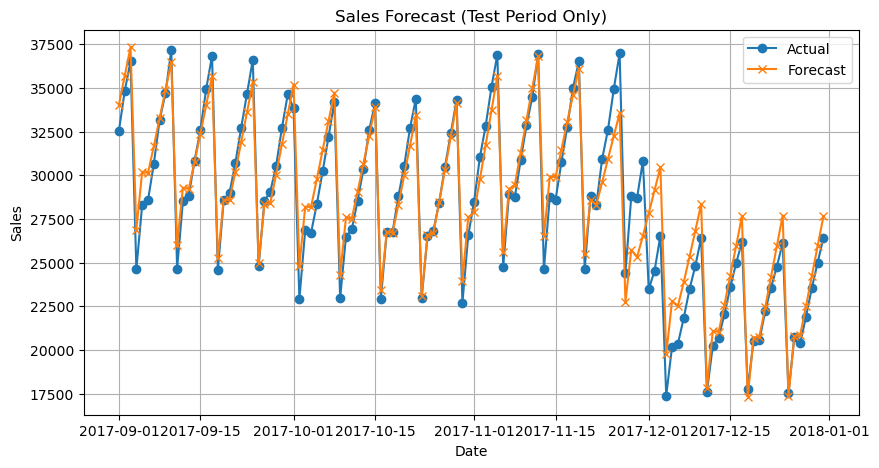

In [18]:
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# 7. Plot only the test period
plt.figure(figsize=(10, 5))
plt.plot(test['ds'], y_true, label='Actual', marker='o')
plt.plot(test['ds'], y_pred, label='Forecast', marker='x')
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Sales Forecast (Test Period Only)")
plt.legend()
plt.grid(True)
plt.show()

# Compare ML models

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error

DATA_PATH = "../data/train.csv"
SPLIT_DATE = "2017-09-01"  # based on your range

def load_daily_series(path=DATA_PATH):
    df = pd.read_csv(path)
    df['date'] = pd.to_datetime(df['date'])
    daily = df.groupby('date')['sales'].sum().reset_index()
    daily = daily.sort_values('date')
    return daily.rename(columns={'date':'ds', 'sales':'y'})

def time_split(df, split_date=SPLIT_DATE):
    train = df[df['ds'] < split_date].copy()
    test  = df[df['ds'] >= split_date].copy()
    return train, test

def evaluate_and_plot(test_ds, y_true, y_pred, title):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(((y_true - y_pred)**2).mean())
    print(f"{title} — MAE: {mae:.2f} | RMSE: {rmse:.2f}")

    plt.figure(figsize=(10,5))
    plt.plot(test_ds, y_true, marker='o', label='Actual')
    plt.plot(test_ds, y_pred, marker='x', label='Forecast')
    plt.title(f"{title}: Test Period Only")
    plt.xlabel("Date"); plt.ylabel("Sales"); plt.grid(True); plt.legend()
    plt.show()
    return mae, rmse


In [ ]:
#Load & split

In [23]:
series = load_daily_series()
train, test = time_split(series)
len(train), len(test), train.head(), test.head()


(1704,
 122,
           ds      y
 0 2013-01-01  13696
 1 2013-01-02  13678
 2 2013-01-03  14488
 3 2013-01-04  15677
 4 2013-01-05  16237,
              ds      y
 1704 2017-09-01  32529
 1705 2017-09-02  34809
 1706 2017-09-03  36521
 1707 2017-09-04  24625
 1708 2017-09-05  28289)

# A) Prophet

19:49:15 - cmdstanpy - INFO - Chain [1] start processing
19:49:17 - cmdstanpy - INFO - Chain [1] done processing


Prophet — MAE: 1020.66 | RMSE: 1388.72


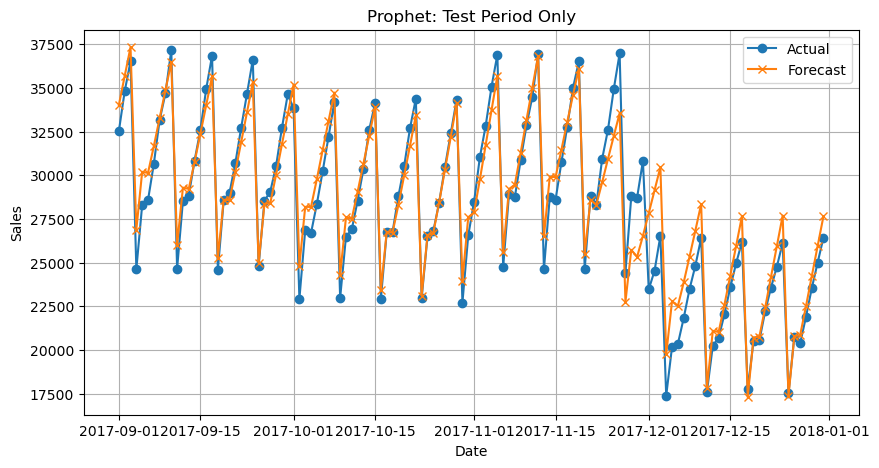

In [24]:
from prophet import Prophet

def run_prophet(train, test):
    m = Prophet()
    m.fit(train.rename(columns={'ds':'ds','y':'y'}))
    future = m.make_future_dataframe(periods=len(test))
    fcst = m.predict(future)
    fcst_test = fcst.iloc[-len(test):]
    y_pred = fcst_test['yhat'].values
    return y_pred

y_pred_prophet = run_prophet(train, test)
mae_p, rmse_p = evaluate_and_plot(test['ds'].values, test['y'].values, y_pred_prophet, "Prophet")


## B) SARIMA (statsmodels)

SARIMA(1,1,1)x(1,1,1,7) — MAE: 3915.25 | RMSE: 5159.17


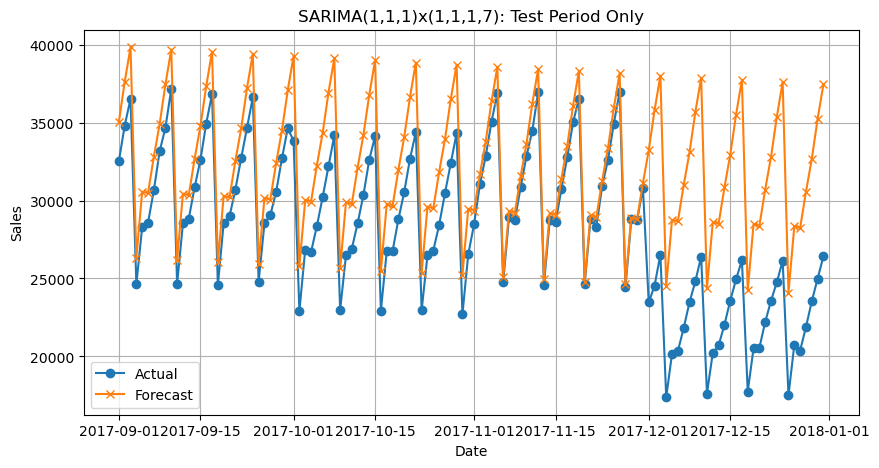

In [30]:
def run_sarima(train, test, order=(1,1,1), seasonal_order=(1,1,1,7)):
    # Fit on training y only
    y_train = train['y'].values
    model = sm.tsa.statespace.SARIMAX(
        y_train,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = model.fit(disp=False)
    # Forecast exactly len(test) steps ahead
    y_pred = res.forecast(steps=len(test))  # returns ndarray
    return y_pred


y_pred_sarima = run_sarima(train, test, order=(1,1,1), seasonal_order=(1,1,1,7))
mae_s, rmse_s = evaluate_and_plot(test['ds'].values, test['y'].values, y_pred_sarima, "SARIMA(1,1,1)x(1,1,1,7)")





## C) XGBoost (lag features)

XGBoost (lags + rolling means) — MAE: 485.04 | RMSE: 864.87


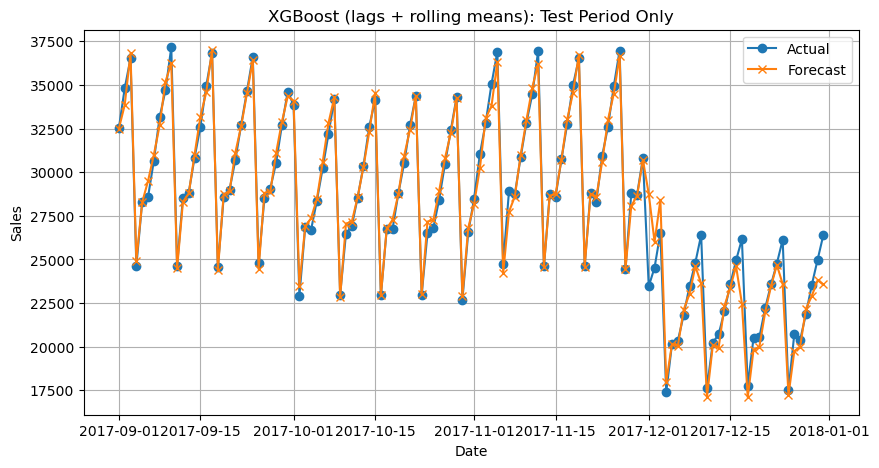

In [31]:
from xgboost import XGBRegressor
from sklearn.preprocessing import OrdinalEncoder

def make_lag_features(df, lags=(1,7,14,28), rolls=(7,14,28)):
    tmp = df.copy()
    for L in lags:
        tmp[f'lag_{L}'] = tmp['y'].shift(L)
    for R in rolls:
        tmp[f'rollmean_{R}'] = tmp['y'].shift(1).rolling(R).mean()
    # Calendar features
    cal = pd.DataFrame({'ds': tmp['ds']})
    cal['dow'] = cal['ds'].dt.dayofweek
    cal['dom'] = cal['ds'].dt.day
    cal['month'] = cal['ds'].dt.month
    cal['week'] = cal['ds'].dt.isocalendar().week.astype(int)
    tmp = tmp.join(cal[['dow','dom','month','week']])
    tmp = tmp.dropna().reset_index(drop=True)
    return tmp

def run_xgb(train, test):
    full = pd.concat([train, test], ignore_index=True)
    feat = make_lag_features(full)

    # Recreate train/test split indices post feature-gen
    split_idx = feat[feat['ds'] < pd.to_datetime(SPLIT_DATE)].index.max()
    X_cols = [c for c in feat.columns if c not in ['ds','y']]
    X_train, y_train = feat.loc[:split_idx, X_cols], feat.loc[:split_idx, 'y']
    X_test,  y_test  = feat.loc[split_idx+1:, X_cols], feat.loc[split_idx+1:, 'y']

    model = XGBRegressor(
        n_estimators=600, max_depth=6, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8, random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    # Align dates for plotting
    test_ds = feat.loc[split_idx+1:, 'ds'].values
    return test_ds, y_test.values, y_pred

test_ds_xgb, y_true_xgb, y_pred_xgb = run_xgb(train, test)
mae_x, rmse_x = evaluate_and_plot(test_ds_xgb, y_true_xgb, y_pred_xgb, "XGBoost (lags + rolling means)")


## D) LSTM (TensorFlow/Keras)


LSTM (lookback=30) — MAE: 7132.37 | RMSE: 9397.48


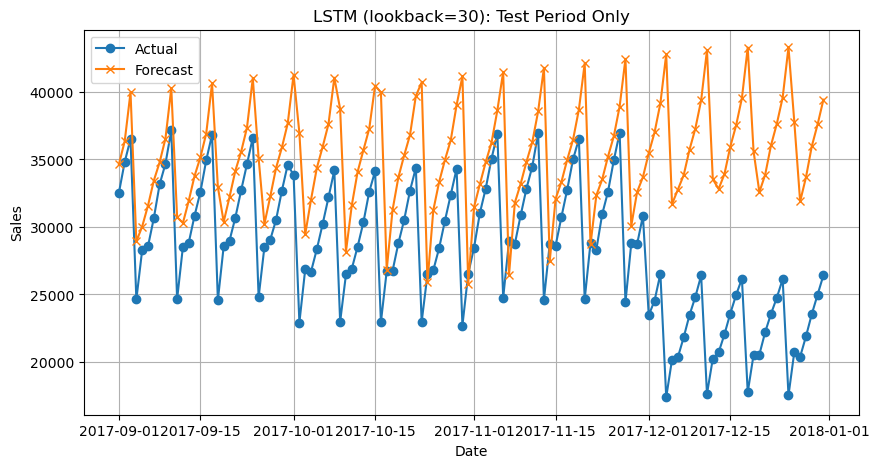

In [36]:
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler

def make_supervised(y, lookback=30):
    X, Y = [], []
    for i in range(lookback, len(y)):
        X.append(y[i-lookback:i])
        Y.append(y[i])
    X, Y = np.array(X), np.array(Y)
    return X, Y

def run_lstm(train, test, lookback=30, epochs=20, batch_size=32):
    # Scale on train only
    scaler = MinMaxScaler()
    y_train = train['y'].values.reshape(-1,1)
    y_test  = test['y'].values.reshape(-1,1)
    y_train_s = scaler.fit_transform(y_train)

    # Train supervised
    Xtr, Ytr = make_supervised(y_train_s.flatten(), lookback)
    Xtr = Xtr.reshape((Xtr.shape[0], Xtr.shape[1], 1))

    model = keras.Sequential([
        keras.layers.Input(shape=(lookback,1)),
        keras.layers.LSTM(64, return_sequences=True),
        keras.layers.LSTM(32),
        keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(Xtr, Ytr, epochs=epochs, batch_size=batch_size, verbose=0)

    # Iterative forecasting over test horizon
    hist_window = y_train_s.flatten()[-lookback:].tolist()
    preds_scaled = []
    for _ in range(len(test)):
        x_in = np.array(hist_window).reshape(1, lookback, 1)
        p = model.predict(x_in, verbose=0)[0,0]
        preds_scaled.append(p)
        # slide window
        hist_window = hist_window[1:] + [p]

    y_pred = scaler.inverse_transform(np.array(preds_scaled).reshape(-1,1)).flatten()
    return y_pred

y_pred_lstm = run_lstm(train, test, lookback=30, epochs=25, batch_size=32)
mae_l, rmse_l = evaluate_and_plot(test['ds'].values, test['y'].values, y_pred_lstm, "LSTM (lookback=30)")


In [38]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler

# ---- helpers
def add_calendar_feats(df):
    out = df.copy()
    out['dow'] = out['ds'].dt.dayofweek
    out['month'] = out['ds'].dt.month
    # cyclic encodings
    out['dow_sin'] = np.sin(2*np.pi*out['dow']/7)
    out['dow_cos'] = np.cos(2*np.pi*out['dow']/7)
    out['m_sin'] = np.sin(2*np.pi*out['month']/12)
    out['m_cos'] = np.cos(2*np.pi*out['month']/12)
    return out

def make_supervised_multistep(df, lookback=90, horizon=7):
    """
    df with columns: ['ds','y', calendar feats ...]
    Returns X:(n, lookback, n_feat), Y:(n, horizon)
    """
    cols = [c for c in df.columns if c not in ['ds']]
    values = df[cols].values
    X, Y = [], []
    for i in range(lookback, len(df)-horizon+1):
        X.append(values[i-lookback:i, :])             # all features
        Y.append(values[i:i+horizon, 0])              # column 0 is y
    return np.array(X), np.array(Y)

# ---- build dataset with features
train_df = train.copy()
test_df  = test.copy()
full_df  = pd.concat([train_df, test_df], ignore_index=True)

full_df = add_calendar_feats(full_df)

# log1p target
full_df['y'] = np.log1p(full_df['y'])

# scale features (fit on train only)
feat_cols = [c for c in full_df.columns if c not in ['ds']]
scaler = MinMaxScaler()
split_idx = len(train_df)  # by rows (train size)
full_df.iloc[:split_idx, 1:] = scaler.fit_transform(full_df.iloc[:split_idx, 1:])
full_df.iloc[split_idx:, 1:] = scaler.transform(full_df.iloc[split_idx:, 1:])

lookback = 90
horizon = 7   # predict a week at a time

X, Y = make_supervised_multistep(full_df, lookback=lookback, horizon=horizon)

# align splits in supervised space
# after windowing, first usable index corresponds to ds[lookback]
usable = full_df.iloc[lookback:]
cut = split_idx - lookback
X_train, Y_train = X[:cut], Y[:cut]
X_test_all, Y_test_all = X[cut:], Y[cut:]  # spans test horizon in overlapping weekly windows

# model
tf.random.set_seed(42)
model = keras.Sequential([
    keras.layers.Input(shape=(lookback, X.shape[2])),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(64),
    keras.layers.Dense(horizon)
])
model.compile(optimizer=keras.optimizers.Adam(1e-3), loss='mse')

cb = [
    keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss'),
    keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.5, min_lr=1e-5)
]

hist = model.fit(
    X_train, Y_train,
    validation_split=0.15,
    epochs=100,
    batch_size=64,
    verbose=0,
    callbacks=cb
)

# roll the weekly predictions to cover the test period exactly
# we’ll take non-overlapping chunks starting from the first test window boundary
steps = int(np.ceil(len(test_df) / horizon))
preds = []
start = 0
for s in range(steps):
    x_in = X_test_all[start:start+1]  # shape (1,lookback,feat)
    if x_in.shape[0] == 0: break
    p = model.predict(x_in, verbose=0)[0]  # (horizon,)
    preds.append(p)
    # advance by horizon in supervised windows
    start += horizon

y_pred_scaled = np.concatenate(preds)[:len(test_df)]
# invert transforms
y_pred = np.expm1(y_pred_scaled)  # invert log1p

# evaluate on test (daily)
from sklearn.metrics import mean_absolute_error, mean_squared_error
y_true = test_df['y'].values  # careful: still log1p currently!
# We need the untransformed true y for metrics
y_true_real = np.expm1(test_df['y'].values)
mae = mean_absolute_error(y_true_real, y_pred)
rmse = np.sqrt(mean_squared_error(y_true_real, y_pred))
print(f"LSTM (multivariate, 7-step) — MAE: {mae:.2f} | RMSE: {rmse:.2f}")

# plot test only
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(test_df['ds'].values, y_true_real, label='Actual', marker='o')
plt.plot(test_df['ds'].values, y_pred, label='LSTM Forecast', marker='x')
plt.title("LSTM (Direct 7‑step): Test Period Only")
plt.xlabel("Date"); plt.ylabel("Sales"); plt.grid(True); plt.legend()
plt.show()


ValueError: Found input variables with inconsistent numbers of samples: [122, 119]

## E) Final comparison


In [37]:
results = pd.DataFrame({
    'Model': ['Prophet', 'SARIMA(1,1,1)x(1,1,1,7)', 'XGBoost', 'LSTM'],
    'MAE':   [mae_p, mae_s, mae_x, mae_l],
    'RMSE':  [rmse_p, rmse_s, rmse_x, rmse_l],
}).sort_values('RMSE')
results


,Model,MAE,RMSE
2,XGBoost,485.039079,864.872702
0,Prophet,1020.657772,1388.716185
1,"SARIMA(1,1,1)x(1,1,1,7)",3915.246751,5159.169894
3,LSTM,7132.374728,9397.476779
